# Part-2 Sentiment Analysis on Amazon Product Reviews

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

In [8]:
# Load csv file
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [9]:
print("Summary statistics of numerical features : \n", df.describe())

print("\n Number of reviews in the dataset: ",len(df))
print("\n Number of brands in the dataset: ", len(list(set(df['Brand Name']))))
print("\n Number of Unique Products: ", len(list(set(df['Product Name']))))

#Assuming rating > 3 as positive,  rating = 3 as negative, rating <3 as negative.
print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  201583.000000  204274.000000  198001.000000
mean      230.414902       3.775326       1.527149
std       317.512781       1.576468       9.358315
min         2.290000       1.000000       0.000000
25%        69.990000       3.000000       0.000000
50%       125.990000       5.000000       0.000000
75%       239.950000       5.000000       1.000000
max      2598.000000       5.000000     487.000000

 Number of reviews in the dataset:  204274

 Number of brands in the dataset:  153

 Number of Unique Products:  1634

Percentage of reviews with neutral sentiment : 7.57%

Percentage of reviews with positive sentiment : 67.63%

Percentage of reviews with negative sentiment : 24.79%


Text(0, 0.5, 'Count')

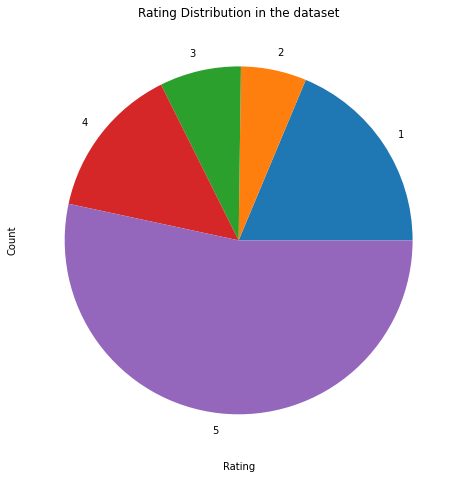

In [10]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='pie')
plt.title('Rating Distribution in the dataset')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 10 Brands')

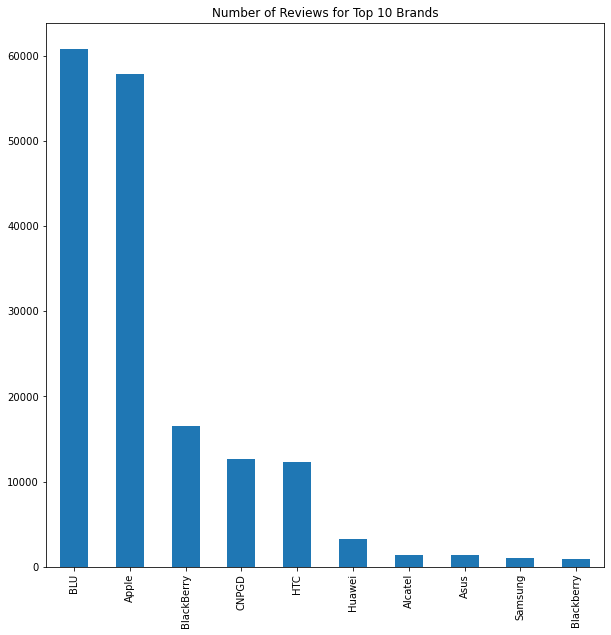

In [11]:
# Plot number of reviews for top 10 brands

#get all brands from the dataset with unique counts
brands = df["Brand Name"].value_counts()
plt.figure(figsize=(10,10))
brands[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 10 Brands")

Text(0.5, 1.0, 'Number of Reviews for top 20 products')

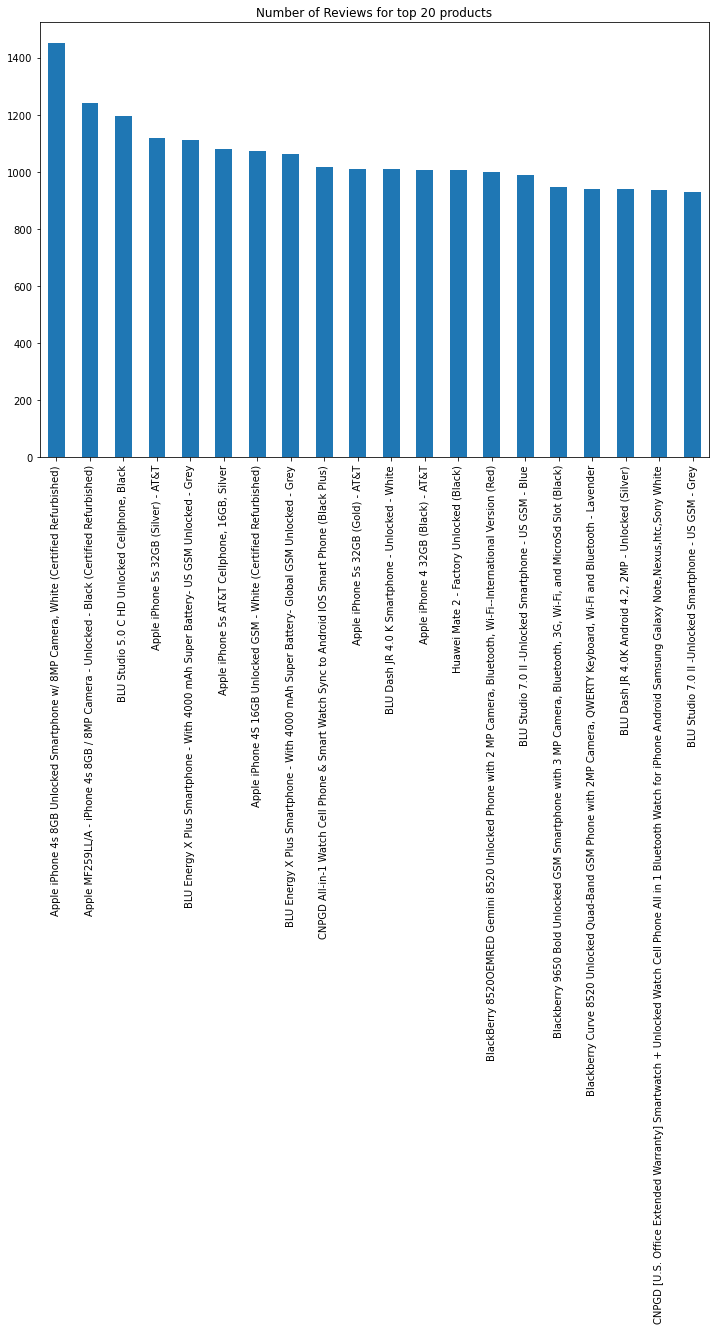

In [12]:
# Plot number of reviews for top 20 products

products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:20].plot(kind='bar')
plt.title("Number of Reviews for top 20 products")

Text(0, 0.5, 'Count')

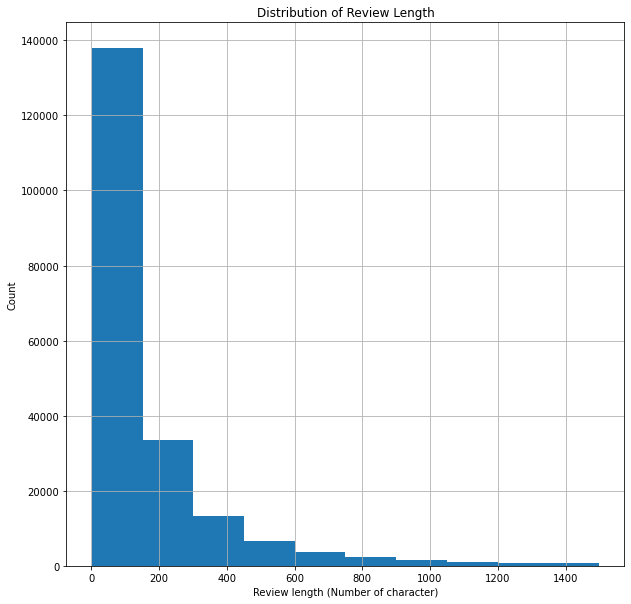

In [13]:
# Plot distribution of review length

#drop nulls from reviews to find out total reviews
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(10,10))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [14]:
df = df.sample(frac=0.2, random_state=12) 
# Drop missing values
df = df.dropna()

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
50233,"Apple iPhone 5s Unlocked Cellphone, 64 GB, Silver",Apple,399.95,5,Good phone!,0.0,1
91271,"Blackberry Curve 8310 Unlocked Phone with GPS,...",BlackBerry,14.87,5,Excellent Product!!! Recommended 100%!!!,0.0,1
203453,Huawei Tap U7519 Unlocked Phone with Touchscre...,Huawei,29.50,4,"I ended buying two, for its great price, thoug...",3.0,1
111854,BLU Dash JR 4.0 K Smartphone - Unlocked - White,BLU,43.95,5,perfect,0.0,1
100544,Blackberry Torch 9800 Unlocked Phone with 5 MP...,BlackBerry,82.62,5,ok thanks all excellent purchase. It is a good...,0.0,1
153458,BLU Studio Selfie - Smartphone - GSM Unlocked ...,BLU,94.99,4,Good,0.0,1
11955,Apple iPhone 4S 16GB (Black) - Verizon,Apple,224.77,5,Does exactly what I want and works with TracFone.,0.0,1
119193,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,4,I really like this phone. It's not heavy in ha...,0.0,1
155342,BLU Studio Selfie 2 - GSM Unlocked Smartphone ...,BLU,69.99,5,Excelente,0.0,1
80657,"ASUS ZenFone 2 Laser Unlocked Smartphone, 3GB ...",ASUS Computers,229.00,3,Loved the device but was disappointed that it ...,0.0,0


In [15]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], test_size=0.2, random_state=12)

print("There are %d training examples and %d validation examples. \n" %(X_train.shape[0],X_test.shape[0]))

There are 27336 training examples and 6835 validation examples. 



In [16]:
#clean reviews
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False ):
    removed_html = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    removed_non_character = re.sub("[^a-zA-Z]", " ", removed_html)  # remove non-character
    words = removed_non_character.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [word for word in words if not word in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(word) for word in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [17]:
# Cleaning train data and test data
X_train_cleaned = []
X_test_cleaned = []

for review in X_train:
    X_train_cleaned.append(cleanText(review))
    
for review in X_test:
    X_test_cleaned.append(cleanText(review))

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/B0193D539M?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You s

In [18]:
#metrics to evaluate different classification models

accuracies = []
auc_scores = []
def modelEvaluation(predictions):
    accuracy  = round(accuracy_score(y_test, predictions), 3)
    auc_score = round(roc_auc_score(y_test, predictions),3)
    accuracies.append(accuracy);auc_scores.append(auc_score)
    print("\nAccuracy on validation set: {:.4f}".format(accuracy))
    print("\nAUC score : {:.4f}".format(auc_score))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [19]:
# Convert words to document term matrix. Fit and transform to the dataset
vect = CountVectorizer() 
X_train_vect = vect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(vect.get_feature_names()))
print("Show some feature names : \n", vect.get_feature_names()[::1000])

Number of features : 17662 

Show some feature names : 
 ['aa', 'assistance', 'bubble', 'compatable', 'defintely', 'ejector', 'finder', 'guts', 'installation', 'llamen', 'mps', 'part', 'promisedall', 'rescued', 'shorcircuited', 'subsequent', 'trajeta', 'walled']


In [20]:
# Train MultinomialNaiveBayes classifier
multinomialNB = MultinomialNB()
multinomialNB.fit(X_train_vect, y_train)

MultinomialNB()

In [21]:
# Evaluate Binomial model on Test Set
predictions = multinomialNB.predict(vect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8950

AUC score : 0.8640

Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      2202
           1       0.90      0.95      0.92      4633

    accuracy                           0.89      6835
   macro avg       0.89      0.86      0.88      6835
weighted avg       0.89      0.89      0.89      6835


Confusion Matrix : 
 [[1711  491]
 [ 230 4403]]


In [22]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
vect = CountVectorizer() #minimum document frequency of 5
X_train_vect = vect.fit_transform(X_train)
print("Number of features : %d \n" %len(vect.get_feature_names())) 

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_vect, y_train)

Number of features : 19046 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))


Top 10 features with smallest coefficients :
['poor' 'worst' 'junk' 'freezes' 'slow' 'stopped' 'returning' 'horrible'
 'broke' 'letter' 'waste' 'broken' 'worthless' 'unusable' 'hate'
 'disappointed' 'empty' 'crashing' 'upset' 'defective']

Top 10 features with largest coefficients : 
['excelente' 'excellent' 'awesome' 'excelent' 'perfect' 'love' 'exelente'
 'wonderful' 'amazing' 'bien' 'pleased' 'perfecto' 'great' 'best' 'loves'
 'exactly' 'accidentally' 'remote' 'affordable' 'happier']


In [24]:
# Evaluate on the validaton set
predictions = lr.predict(vect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9130

AUC score : 0.8890

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      2202
           1       0.92      0.96      0.94      4633

    accuracy                           0.91      6835
   macro avg       0.91      0.89      0.90      6835
weighted avg       0.91      0.91      0.91      6835


Confusion Matrix : 
 [[1804  398]
 [ 194 4439]]


In [25]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) 
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 5706 

Show some feature names : 
 ['00', 'claiming', 'fixed', 'mailed', 'reasonable', 'telefono']


LogisticRegression()

In [26]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))


Top 10 features with smallest coefficients :
['not' 'doesn' 'return' 'slow' 'poor' 'disappointed' 'stopped' 'waste'
 'worst' 'returning' 'refund' 'horrible' 'broken' 'wasn' 'broke' 'tried'
 'wouldn' 'freezes' 'junk' 'terrible']

Top 10 features with largest coefficients : 
['love' 'great' 'excellent' 'perfect' 'awesome' 'amazing' 'best'
 'excelente' 'easy' 'excelent' 'perfectly' 'loves' 'nice' 'everything'
 'happy' 'pleased' 'exactly' 'good' 'fast' 'wonderful']


In [27]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9100

AUC score : 0.8870

Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.82      0.86      2202
           1       0.92      0.95      0.94      4633

    accuracy                           0.91      6835
   macro avg       0.91      0.89      0.90      6835
weighted avg       0.91      0.91      0.91      6835


Confusion Matrix : 
 [[1808  394]
 [ 219 4414]]


In [28]:
from sklearn import ensemble 


#random forest with CountVectorizer
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train_vect, y_train) #X_train_vect = document term matrix

feature_names = np.array(vect.get_feature_names())

# Evaluate on the validaton set
predictions = rfc.predict(vect.transform(X_test_cleaned))
modelEvaluation(predictions)


#Longer time to train


Accuracy on validation set: 0.9300

AUC score : 0.9070

Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      2202
           1       0.93      0.97      0.95      4633

    accuracy                           0.93      6835
   macro avg       0.93      0.91      0.92      6835
weighted avg       0.93      0.93      0.93      6835


Confusion Matrix : 
 [[1850  352]
 [ 124 4509]]


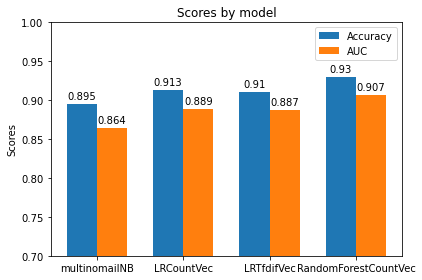

In [29]:
#borrowed form https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
labels = ["multinomailNB","LRCountVec","LRTfdifVec","RandomForestCountVec"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, auc_scores, width, label='AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_ylim(0.7,1.0)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Part-3 Experiments -1

### Word2Vec Model, Feature Vectors, Random Forest Classifier, Simple LSTM and LSTM with Word2Vec

In [30]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
import nltk
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


27301 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['do', 'not', 'waste', 'your', 'money', 'buying', 'this', 'phone', 'is', 'really', 'rubbish', 'the', 'phone', 'gets', 'very', 'hot', 'and', 'off', 'every', 'minutes', 'the', 'phone', 'has', 'only', 'months', 'of', 'use', 'and', 'not', 'used', 'is', 'a', 'waste', 'of', 'money', 'i', 'regret', 'not', 'buying', 'a', 'phone', 'from', 'real', 'manufacturers', 'motorola', 'samsung', 'sony', 'huawei', 'lg', 'blu', 'is', 'not', 'only', 'sells', 'generic', 'phone', 'manufacturer', 'shoddy', 'pure', 'blu', 'xl', 'is', 'equal', 'gionne', 'e', 'and', 'allview', 'soul', 'extreme', 'x', 'are', 'generic', 'phones', 'do', 'not', 'buy', 'do', 'not', 'buy', 'blu', 'blu', 'not', 'buy', 'blu', 'blu', 'not', 'buy', 'do', 'not', 'buy', 'blu']


In [33]:
# Fit parsed sentences to Word2Vec model 
num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_model") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index_to_key ))
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index_to_key[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 3805 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'it', 'and', 'phone', 'a', 'to', 'is', 'this', 'for']


<ipython-input-33-c1a1148267f1>:13: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)


In [34]:
# Transfrom the training data into feature vectors
def makeFeatureVec(review, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index_to_key) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model.wv.key_to_index[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [35]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/B0193D539M?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You s

Training set : 27336 feature vectors with 300 dimensions
Validation set : 6835 feature vectors with 300 dimensions


In [36]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.7550

AUC score : 0.7070

Classification report : 
               precision    recall  f1-score   support

           0       0.63      0.57      0.60      2202
           1       0.81      0.84      0.82      4633

    accuracy                           0.75      6835
   macro avg       0.72      0.71      0.71      6835
weighted avg       0.75      0.75      0.75      6835


Confusion Matrix : 
 [[1263  939]
 [ 738 3895]]


In [37]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3

# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape)
print('X_test shape:', X_test_seq.shape) 
print('y_train shape:', y_train_seq.shape) 
print('y_test shape:', y_test_seq.shape) 

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (27336, 100)
X_test shape: (6835, 100)
y_train shape: (27336, 2)
y_test shape: (6835, 2)


In [41]:
# Construct a simple LSTM
Simple_LSTM = Sequential()
Simple_LSTM.add(Embedding(top_words, 128))
Simple_LSTM.add(LSTM(128, dropout=0.2)) 
Simple_LSTM.add(Dense(nb_classes))
Simple_LSTM.add(Activation('softmax'))
Simple_LSTM.summary()

# Compile LSTM
Simple_LSTM.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Simple_LSTM.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evluation
score = Simple_LSTM.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
855/855 [==============================] - 68s 79ms/step - loss: 0.3236 - accuracy: 0.8650
Epoch 2/3
855/855 [==============================] - 67s 78ms/step - loss: 0.1894 - accuracy: 0.9324
Epoch 3/3
214/214 [=====================

In [43]:
# Loading trained Word2Vec model
w2v = Word2Vec.load("w2v_model")

embedding_matrix = w2v.wv.vectors 
print("Shape of embedding matrix : ", embedding_matrix.shape) 

Shape of embedding matrix :  (3805, 300)


In [44]:
top_words = embedding_matrix.shape[0] 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3

# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) 
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) 
print('X_test shape:', X_test_seq.shape) 
print('y_train shape:', y_train_seq.shape) 
print('y_test shape:', y_test_seq.shape) 

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (27336, 100)
X_test shape: (6835, 100)
y_train shape: (27336, 2)
y_test shape: (6835, 2)


In [45]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], 
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix])

# Construct LSTM with Word2Vec embedding
Embedding_LSTM = Sequential()
Embedding_LSTM.add(embedding_layer)
Embedding_LSTM.add(LSTM(128, dropout=0.2)) 
Embedding_LSTM.add(Dense(nb_classes))
Embedding_LSTM.add(Activation('softmax'))
Embedding_LSTM.summary()

# Compile model
Embedding_LSTM.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Embedding_LSTM.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evaluation
score = Embedding_LSTM.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         1141500   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 1,361,406
Trainable params: 1,361,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
855/855 [==============================] - 67s 78ms/step - loss: 0.3137 - accuracy: 0.8674
Epoch 2/3
855/855 [==============================] - 62s 73ms/step - loss: 0.2055 - accuracy: 0.9240
Epoch 3/3
214/214 [=====================